In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotting_tools as pt
%matplotlib inline

from matplotlib.patches import Ellipse
from scipy.stats import norm

from cluster_methods import *

from sklearn import decomposition
import skfuzzy as fuzz
from sklearn import preprocessing

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)

from scipy import linalg

from sklearn.mixture import GMM

def fuzzy_clustering():
    return
    
# exploring the properties of galaxies through multidimensional statistical analysis techniques 
# vespa data, galaxy zoo data, sdss
# 0: stellar mass
# 1: error
# 2: SFR last 115 Myr
# 3: dustVal ISM
# 4: redshift
# 5: prob. elliptical
# 6: prob. spiral
# 7: u
# 8: g
# 9: r
# 10: i
# 11: z
# 12: petro r
# 13: theta

# PCA analysis followed by fuzzy clustering

In [2]:
galaxies = np.load('/home/calum/Documents/Mphys_data/vespa_data/vespa_properties.npy')
len(galaxies)

417270

data = []

#create dataset for clustering
for row in galaxies:
    #if (row[4] > 0.004 and row[4] < 0.08) :
        # absolute r-band petrosian magnitude
        x0 = float(row[12])-5*(np.log10(cosmo.luminosity_distance(row[4]).to(u.pc).value/10))
        # u-r colour
        x1 = row[7]-row[9]
        # redshift
        x2 = row[4]
        # morphology
        if row[5] > 0.8:
            # elliptical
            x3 = 1
        elif row[6] > 0.8:
            # spiral
            x3 = -1
        else:
            # should we ommit these?
            x3 = 0
        # ISM dust value
        x4 = row[3]
        # log(stellar mass)
        x5 = np.log(row[0])
        # surface brightness
        x6 = row[9]+2.5*np.log10(2*np.pi*row[13]*row[13])

        # append to data
        data.append([x0,x1,x2,x3,x4,x5,x6])

np.save('/home/calum/Documents/Mphys_data/vespa_data/tmp_vespa_data',data)

In [3]:
data = np.load('/home/calum/Documents/Mphys_data/vespa_data/tmp_vespa_data.npy')

In [4]:
data = np.array(data)
np.array([[row[1],row[0]] for row in data]).shape

(417270, 2)

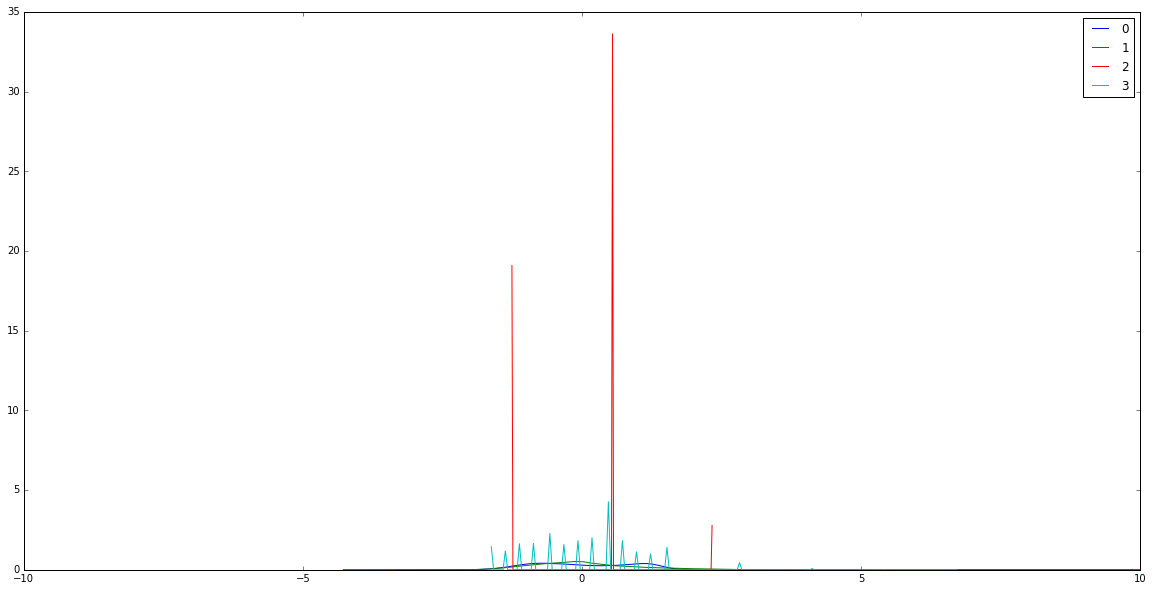

(137204, 3)


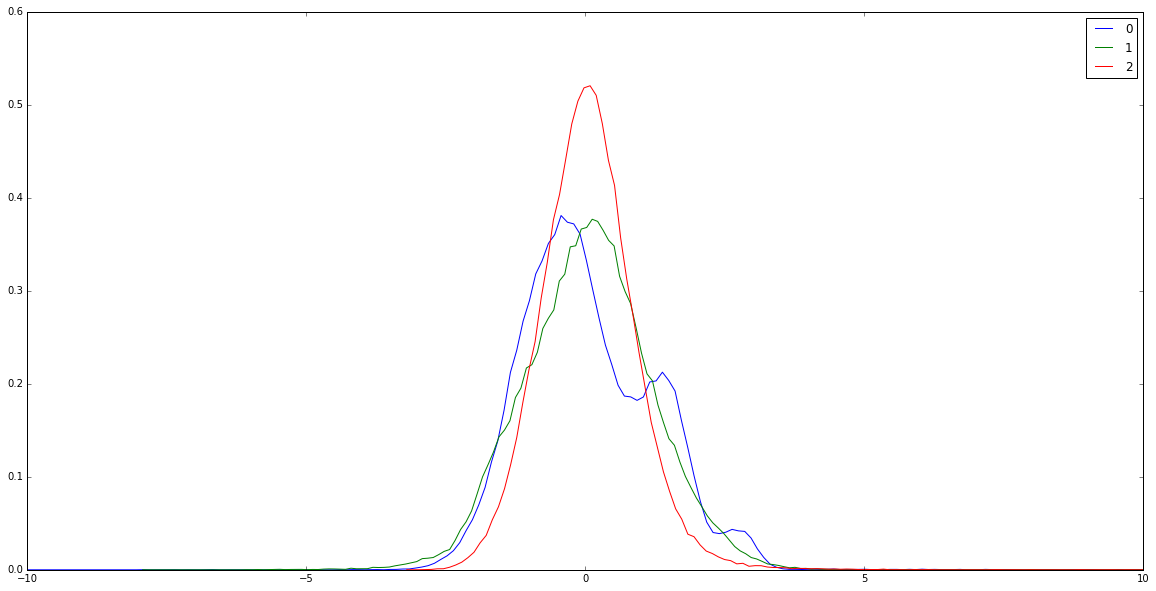

Conducting cluster analysis...
Number of iterations: 499 FPC 0.628358148816
cluster membership (137204,)
u shape (2, 137204)
Length of cluster 0 : 63317
Length of cluster 1 : 73887


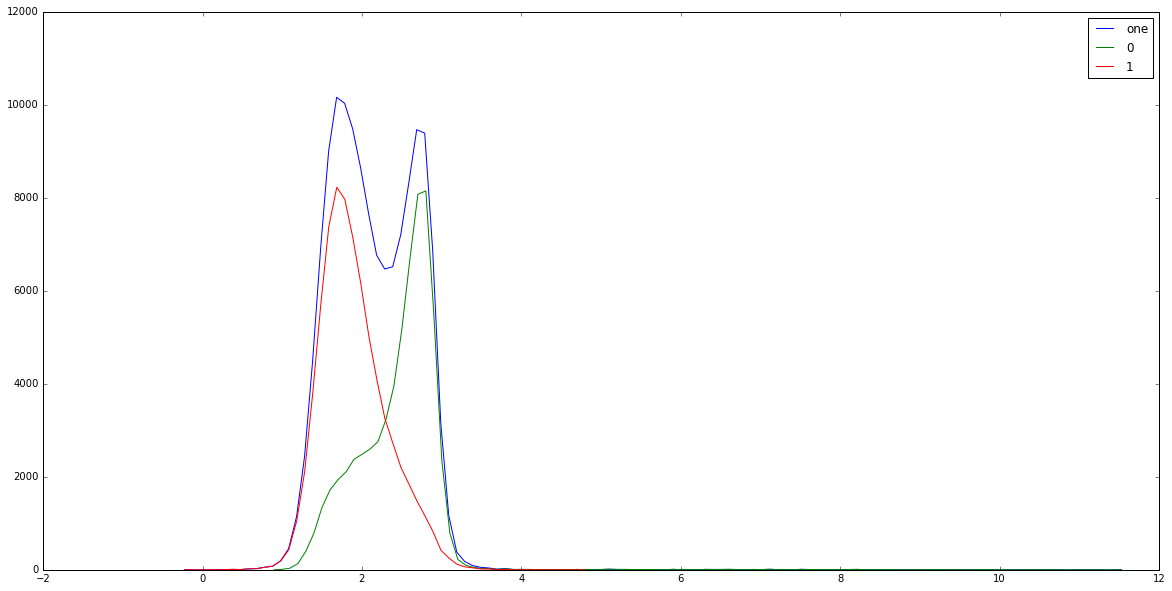

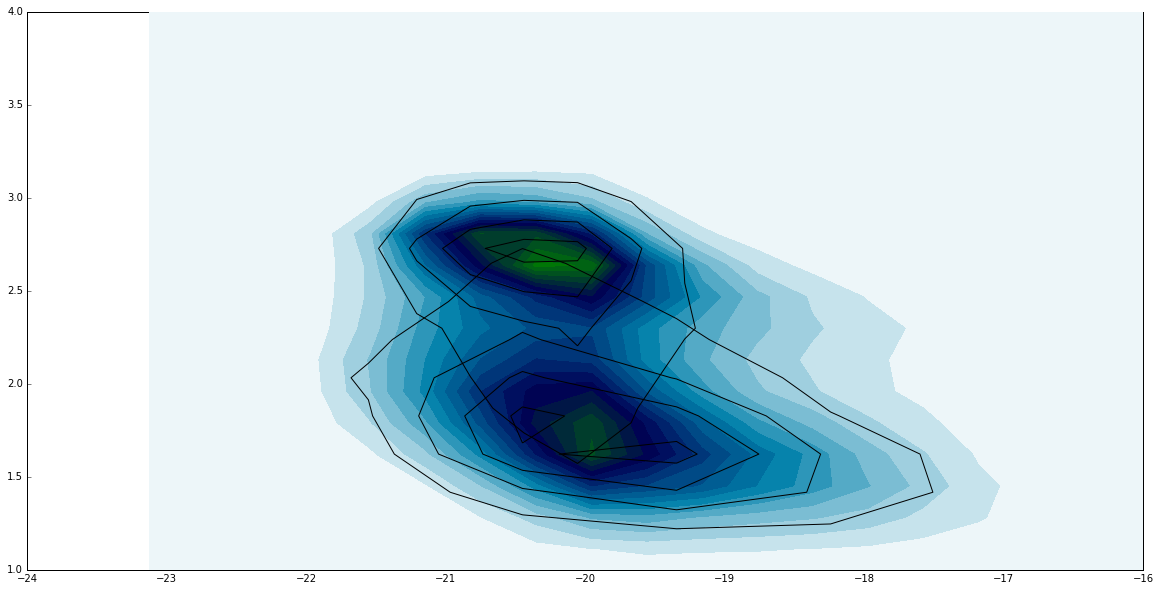

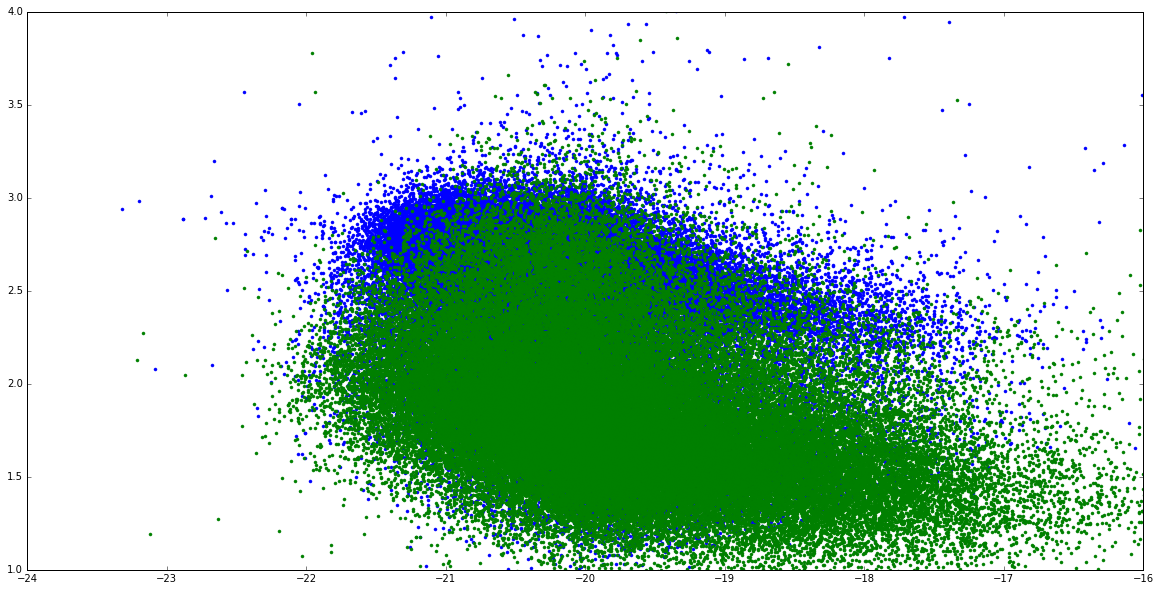

In [5]:
u0 = fclustering([[row[1],row[0],row[3],row[4]] for row in data if row[2]<0.08],2,n_pca='mle',error=1e-20)

In [8]:
all_data = np.array([[row[0],row[1]] for row in data if row[2]<0.08])
sall_data = preprocessing.scale(all_data,axis=0)

sall_data = np.array([[row[0],row[1]*100] for row in sall_data])
sall_data.shape

(137204, 2)

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


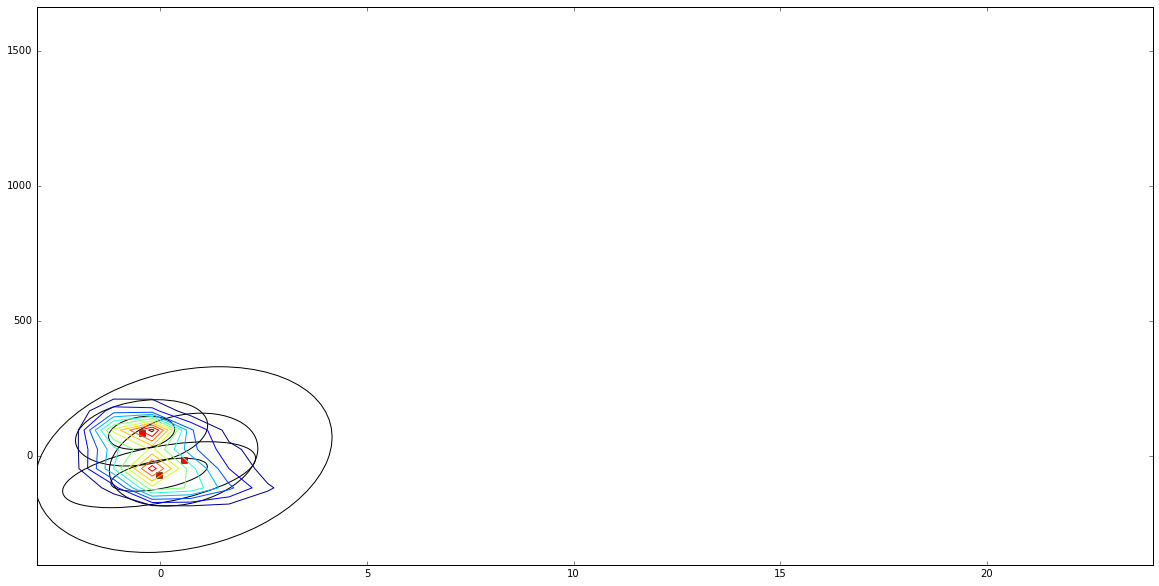

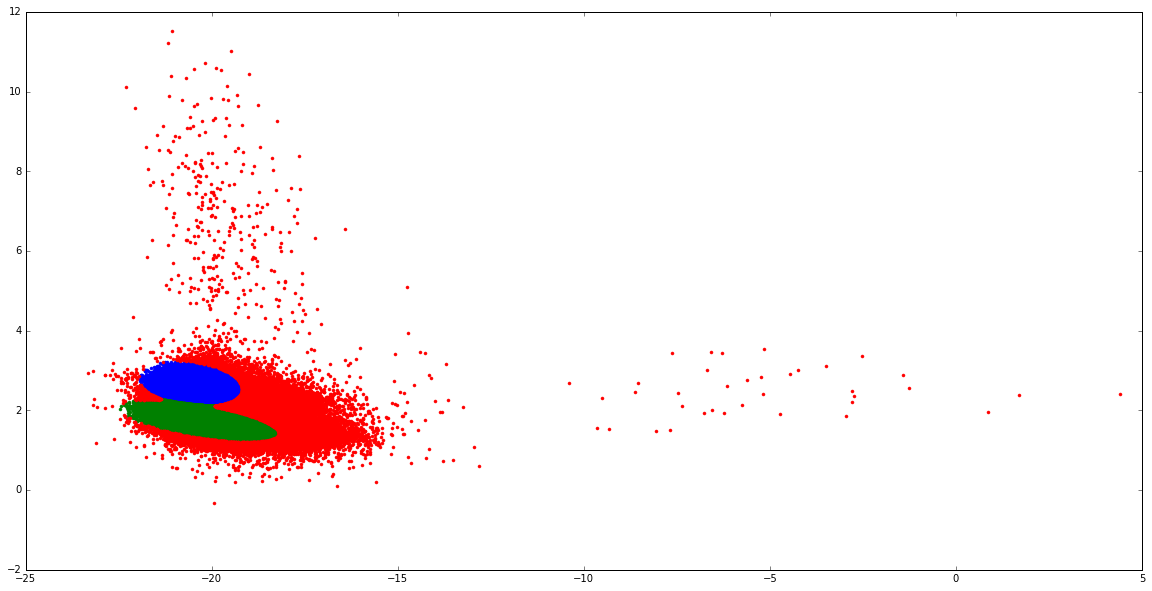

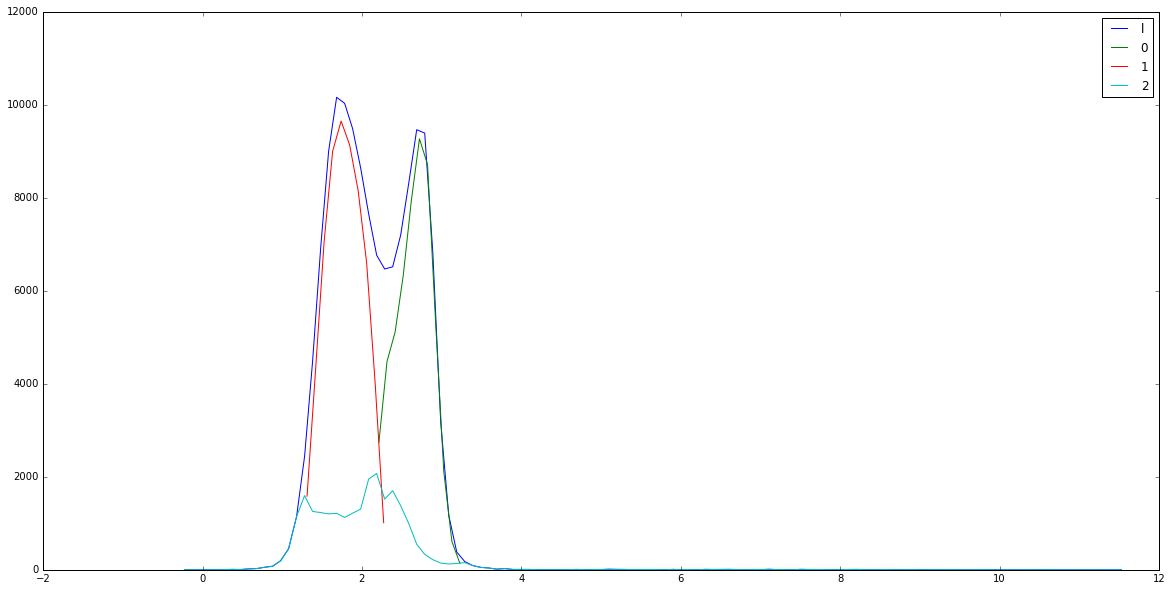

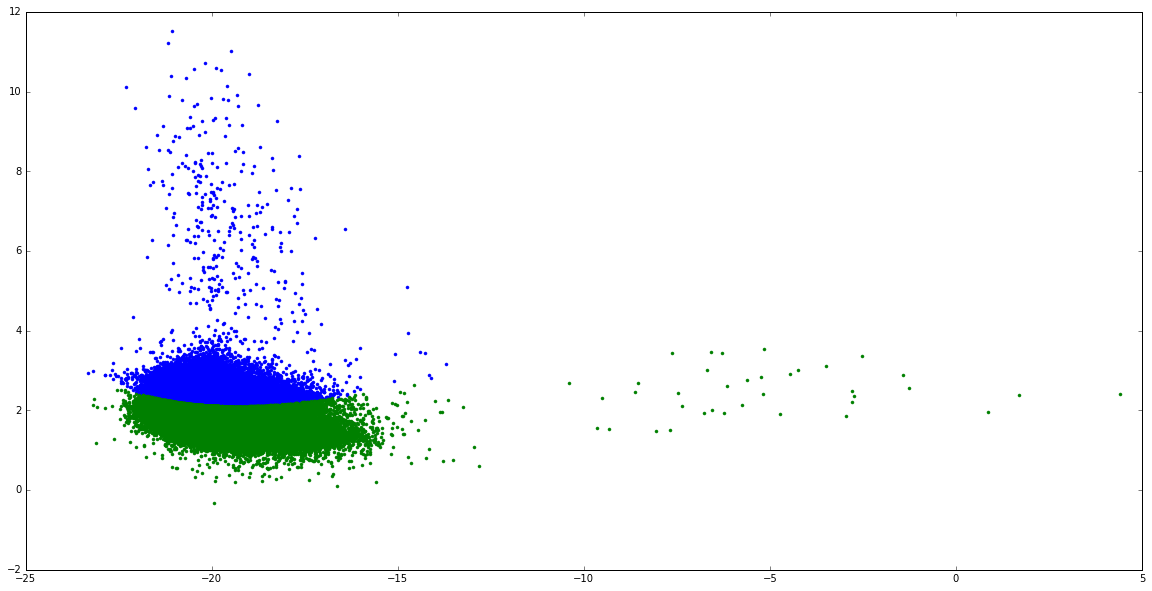

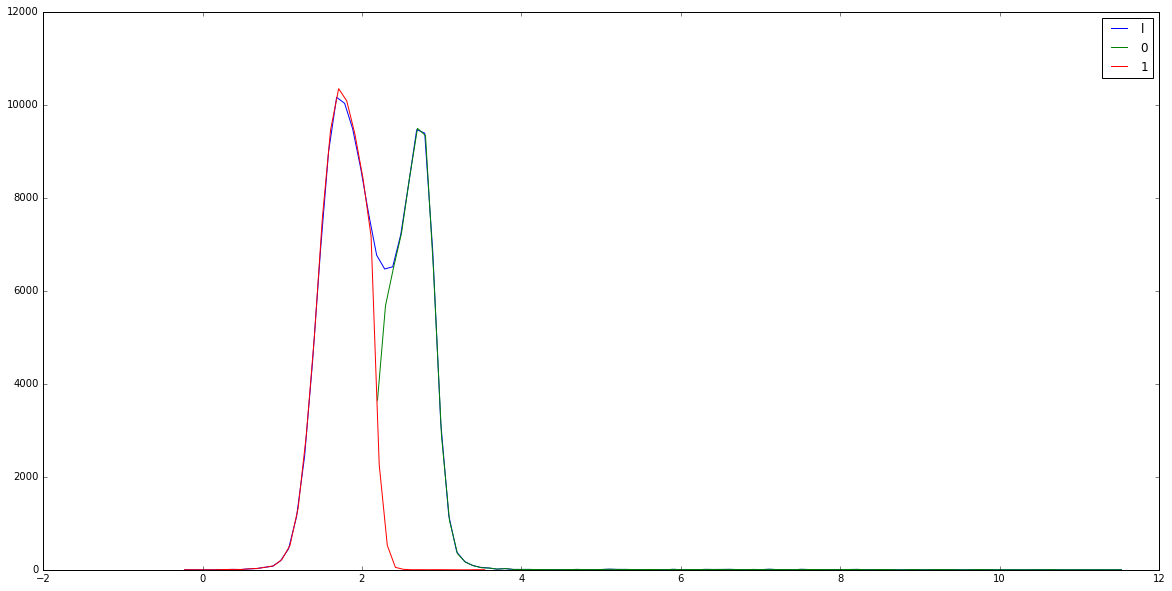

In [9]:
gmm_clustering(all_data,sall_data,3,500,'mc','full')

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


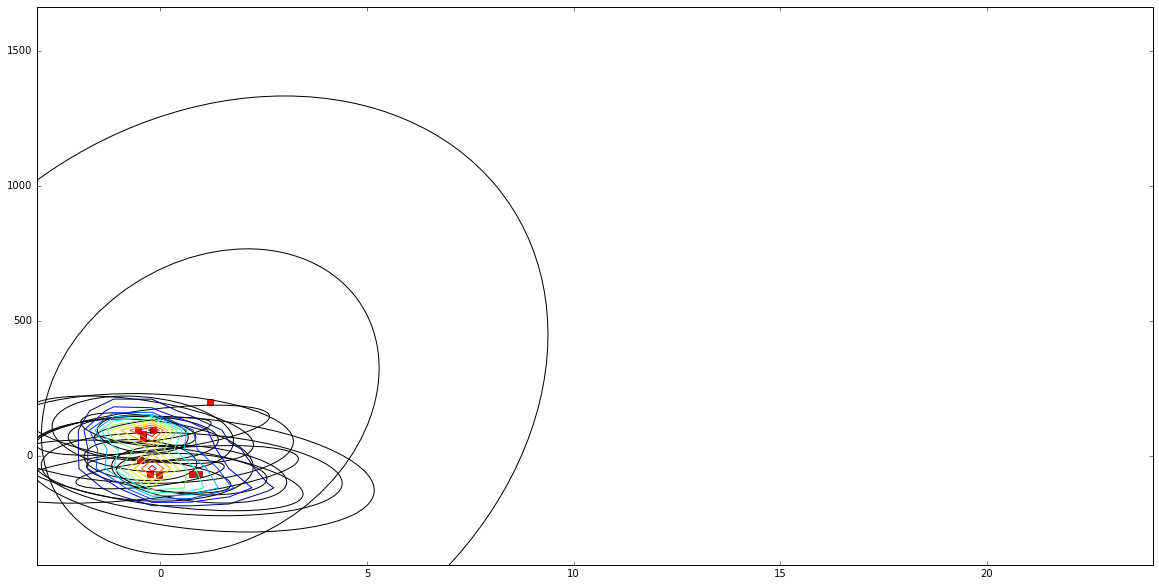

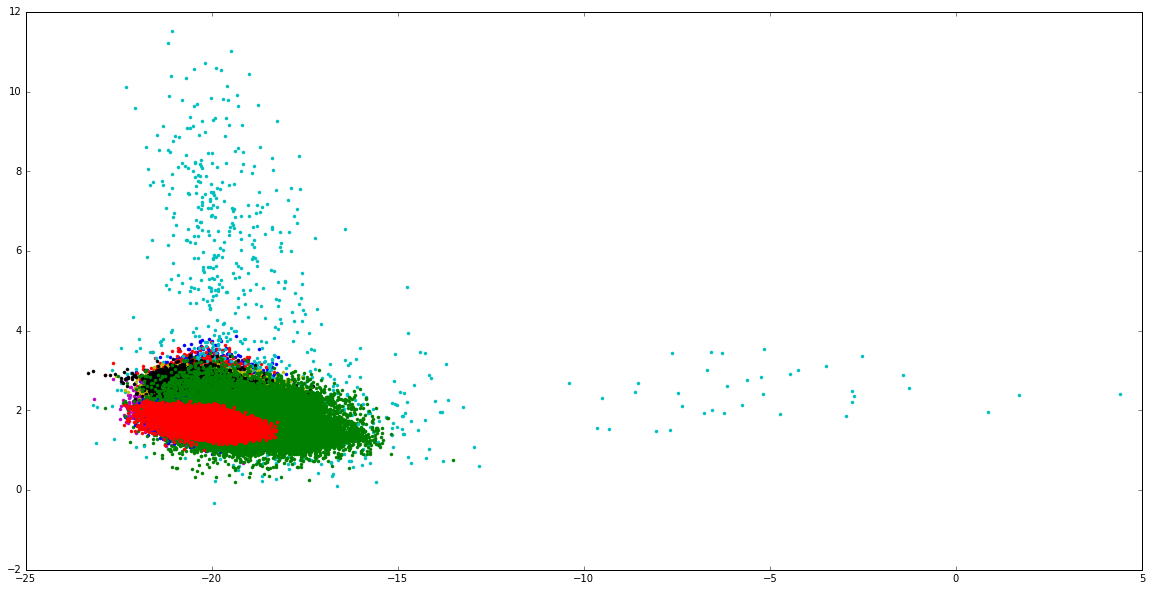

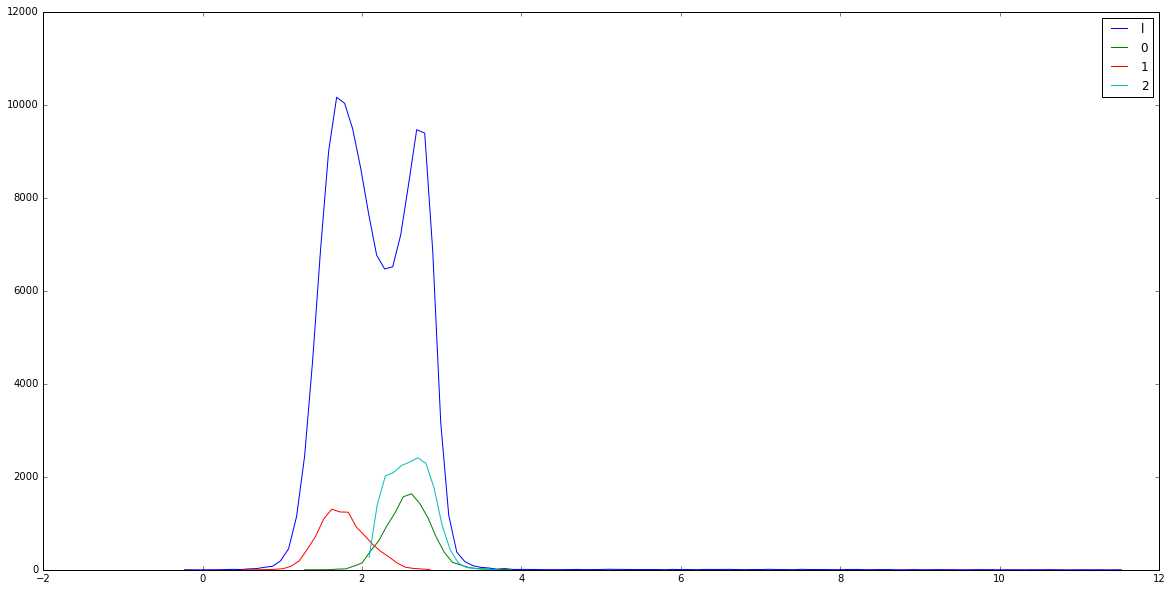

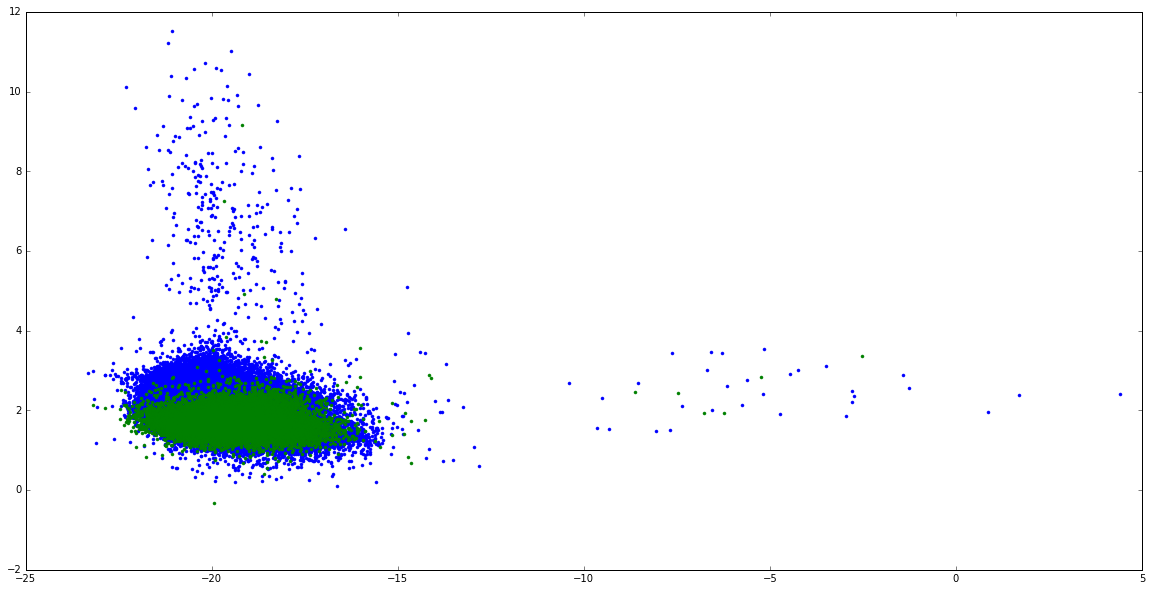

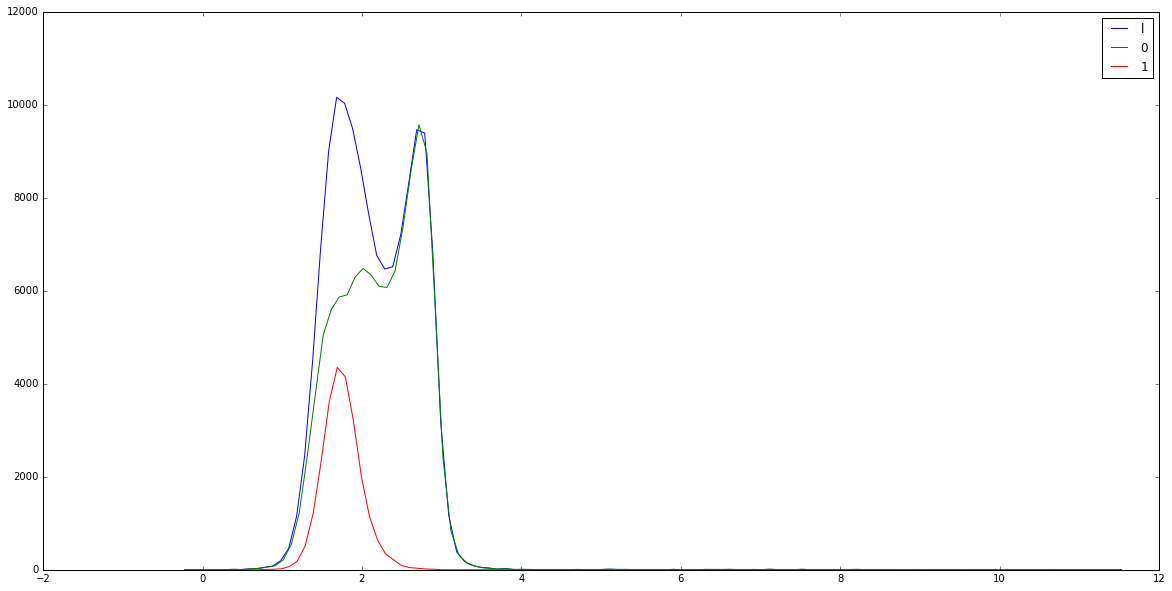

In [16]:
all_data = np.array([[row[0],row[1],row[3],row[4],row[5],row[6]] for row in data if row[2]<0.08])
sall_data = preprocessing.scale(all_data,axis=0)

sall_data = np.array([[row[0],row[1]*100,row[2],row[3],row[4],row[5]] for row in sall_data])
sall_data.shape

gmm_clustering(all_data,sall_data,10,500,'mc','full')

In [ ]:
# below is original workings, still some useful stuff in there

In [8]:
gmm = GMM(3,n_iter=500,params='mc',covariance_type='full')
gmm.fit(sall_data)
log_dens = gmm.score(sall_data)
BIC = gmm.bic(sall_data)
BIC

1978696.1036750099

In [66]:
log_dens.shape

(137204,)

In [67]:
for i in range(gmm.n_components):
        print('Mean',gmm.means_[i])
        print('Covar',gmm.covars_[i])

Mean [ -0.45682986  85.92598084]
Covar [[  3.19820671e-01  -5.71049244e+00]
 [ -5.71049244e+00   1.88248621e+03]]
Mean [ -3.29733801e-02  -6.91278198e+01]
Covar [[  6.81974341e-01  -1.78308362e+01]
 [ -1.78308362e+01   1.86293829e+03]]
Mean [  0.56049775 -13.15575953]
Covar [[  1.61420991e+00  -3.72626529e+01]
 [ -3.72626529e+01   1.47764882e+04]]


(-200, 300)

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


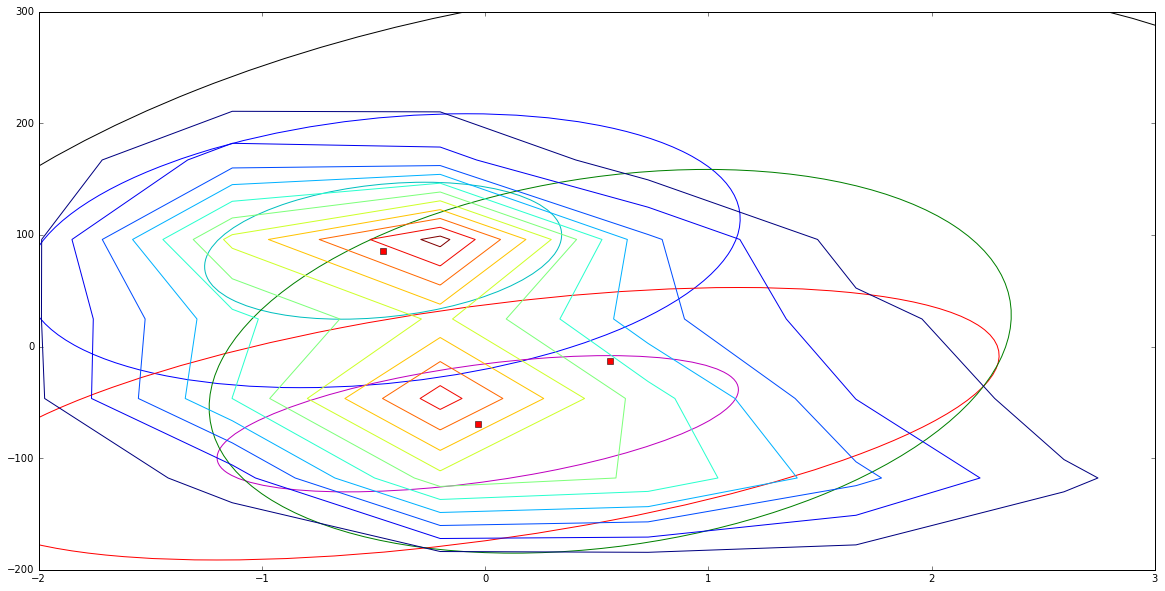

In [68]:
# Visualize the test data
fig0, ax0 = plt.subplots(figsize=(20,10))

x = np.array([row[0] for row in sall_data])
y = np.array([row[1] for row in sall_data])

pt.plot_contour(x,y,lines=15)

colours = [['c','b'],['m','r'],['g','k']]

for i in range(gmm.n_components):
    mean = gmm.means_[i][:2]
    #covar = [[gmm.covars_[i][0],0],[0,gmm.covars_[i][1]]]
    covar = gmm.covars_[i]
    v,w = linalg.eig(covar)
    v = 2.* np.sqrt(2.)*np.sqrt(v)
    u = w[0]/linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ax0.plot(gmm.means_[i][0],gmm.means_[i][1],'rs')
    ax0.add_artist(Ellipse(mean,2*v[0],2*v[1],180.+angle,color=colours[i][1],fill=False))
    ax0.add_artist(Ellipse(mean,v[0],v[1],180.+angle,color=colours[i][0],fill=False))

    
plt.xlim(-2,3)
plt.ylim(-200,300)
    

In [69]:
cluster_centres = gmm.means_
cluster_centres.shape

(3, 2)

In [70]:
tgmm = GMM(2,n_iter=500,params='mc',covariance_type='full')
tgmm.fit(cluster_centres)
log_dens = tgmm.score(cluster_centres)
BIC = tgmm.bic(cluster_centres)

(-200, 300)

/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


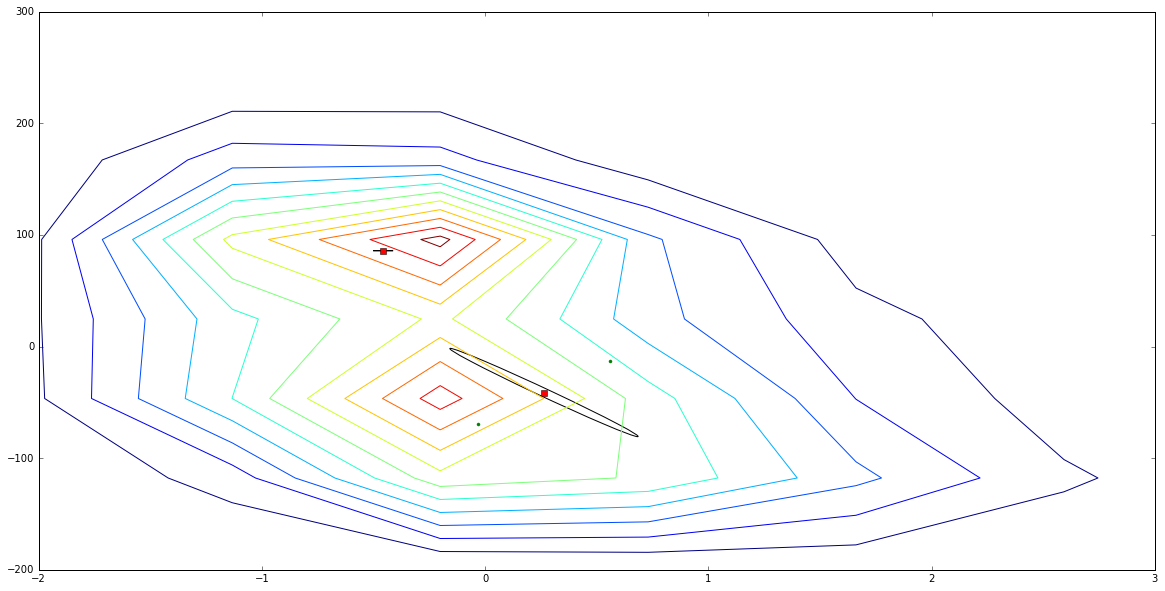

In [71]:
# Visualize the test data
fig0, ax0 = plt.subplots(figsize=(20,10))

x = np.array([row[0] for row in sall_data])
y = np.array([row[1] for row in sall_data])

pt.plot_contour(x,y,lines=15)

for row in cluster_centres:
    plt.plot(row[0],row[1],'g.')

for i in range(tgmm.n_components):
    mean = tgmm.means_[i]
    #covar = [[tgmm.covars_[i][0],0],[0,tgmm.covars_[i][1]]]
    covar = tgmm.covars_[i]
    v,w = linalg.eig(covar)
    v = 2.* np.sqrt(2.)*np.sqrt(v)
    u = w[0]/linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ax0.plot(tgmm.means_[i][0],tgmm.means_[i][1],'rs')
    ax0.add_artist(Ellipse(mean,v[0],v[1],180.+angle,color='k',fill=None))
    
plt.xlim(-2,3)
plt.ylim(-200,300)

5


/home/calum/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:1965: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float_)


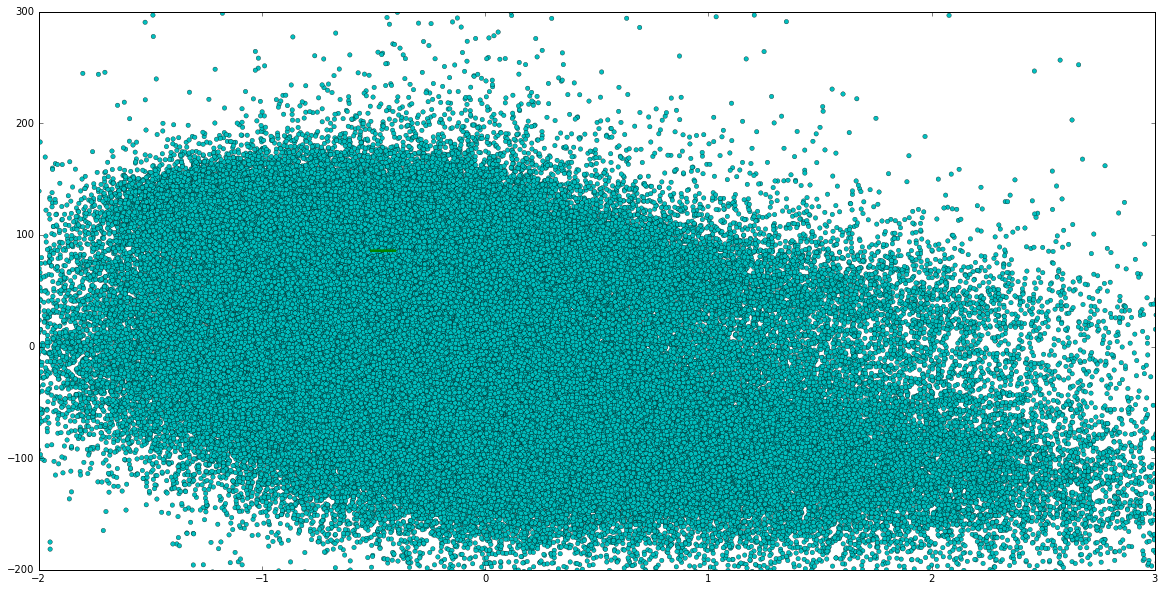

In [72]:
fig,ax = plt.subplots(1,figsize=(20,10))

# Some test points
x = np.array([row[0] for row in sall_data])
y = np.array([row[1] for row in sall_data])

# The ellipse
g_ell_center = mean
g_ell_width = 1.3*v[0]
g_ell_height = 1.3*v[1]
angle = angle

g_ellipse = Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=angle, fill=False, color='g', linewidth=2, alpha=1)
ax.add_artist(g_ellipse)

cos_angle = np.cos(np.radians(180.-angle))
sin_angle = np.sin(np.radians(180.-angle))

xc = x - g_ell_center[0]
yc = y - g_ell_center[1]

xct = xc * cos_angle - yc * sin_angle
yct = xc * sin_angle + yc * cos_angle 

rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

colors_array = []

count = 0
blue_sequence = []
mask = []

for i,r in enumerate(rad_cc):
    if r <= 1.:
        # point in ellipse
        colors_array.append('green')
        count += 1
        blue_sequence.append(y[i])
        mask.append(1)
    else:
        # point not in ellipse
        colors_array.append('c')
        mask.append(0)
        
ax.scatter(x,y,c=colors_array,linewidths=0.3)

print(count)
plt.xlim(-2,3)
plt.ylim(-200,300)
plt.show()

ValueError: `bins` should be a positive integer.

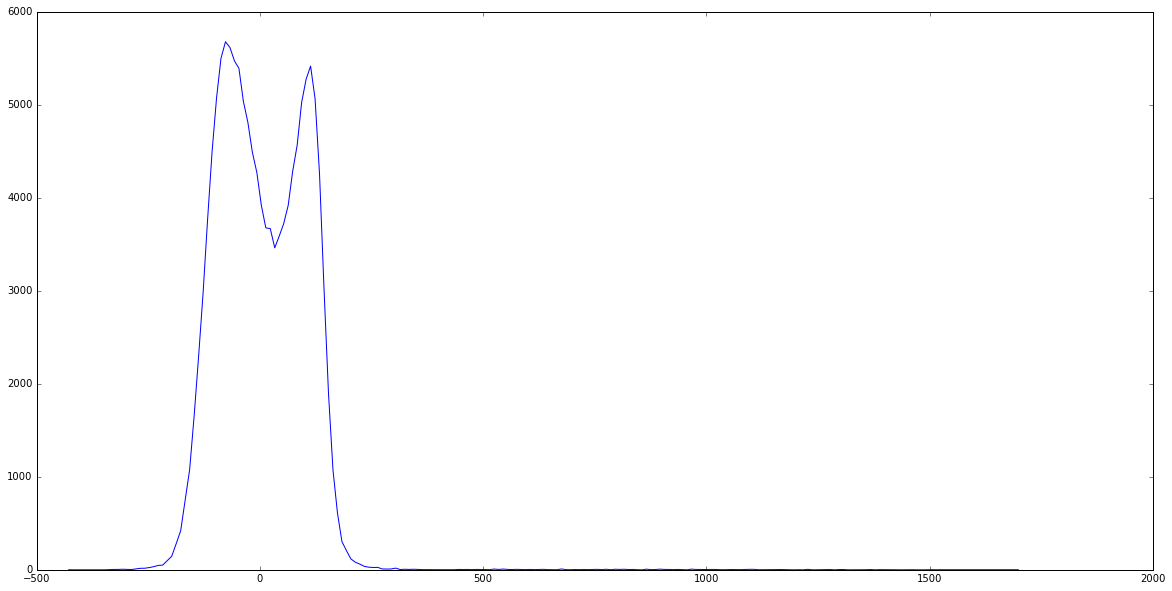

In [73]:
plt.figure(figsize=(20,10))
pt.plot_hist(y,200,'l',set_bin_size=True,bin_size=10,normed=False)
pt.plot_hist(blue_sequence,200,'l',set_bin_size=True,bin_size=10,normed=False)

ValueError: `bins` should be a positive integer.

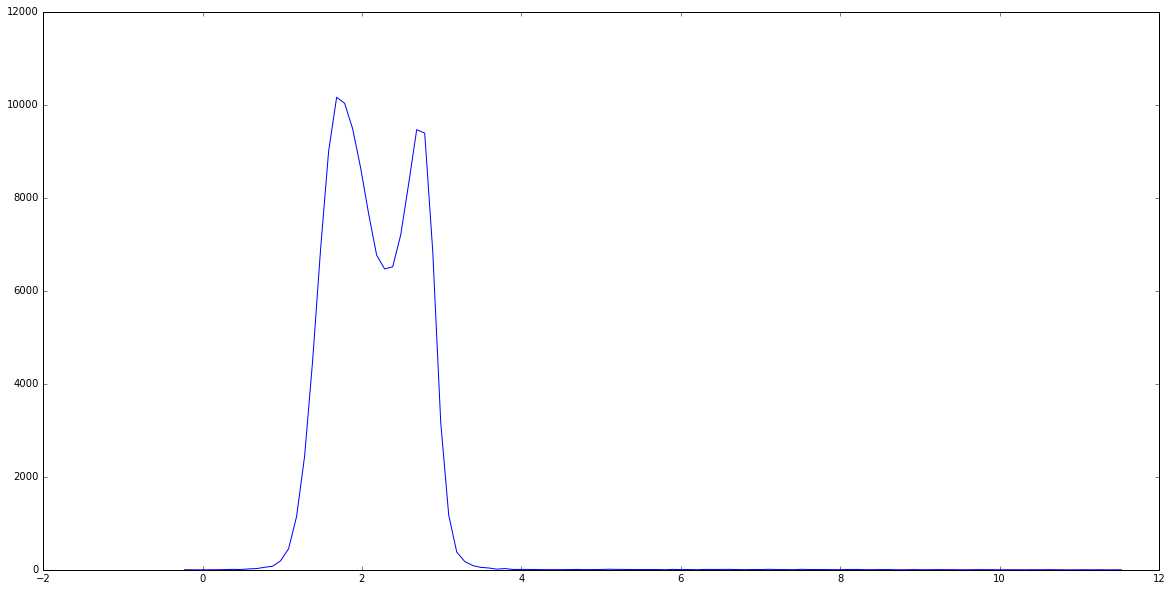

In [74]:
colours = np.array([row[1] for row in all_data])

plt.figure(figsize=(20,10))
pt.plot_hist(colours,200,'l',set_bin_size=True,bin_size=0.1,normed=False)
pt.plot_hist(colours[np.array(mask)==1],200,'l',set_bin_size=True,bin_size=0.1,normed=False)

In [75]:
cluster_probs = gmm.predict_proba(sall_data)
cluster_probs.shape

(137204, 3)

In [76]:
cluster_membership = np.argmax(cluster_probs.T, axis=0)
cluster_membership.shape

(137204,)

In [77]:
colors = ['b','r','g','c','c','m','y','k','Brown','ForestGreen']

(1, 4)

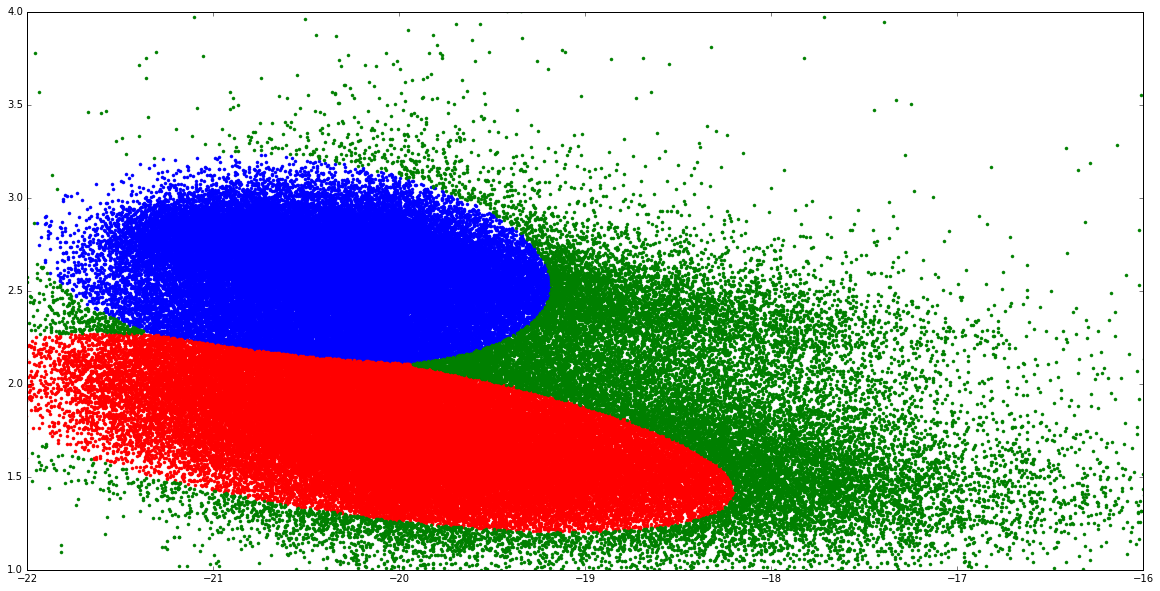

In [78]:
plt.figure(figsize=(20,10))

xpts = np.array([row[0] for row in all_data])
ypts = np.array([row[1] for row in all_data])

for i in range(3):
    plt.plot(xpts[cluster_membership==i], ypts[cluster_membership==i], '.',color=colors[i])
    
plt.xlim(-22,-16)
plt.ylim(1,4)

In [79]:
two_cluster_probs= cluster_probs.T[:2]
two_cluster_probs.shape

(2, 137204)

In [80]:
tcluster_membership = np.argmax(two_cluster_probs, axis=0)
tcluster_membership.shape

(137204,)

(1, 4)

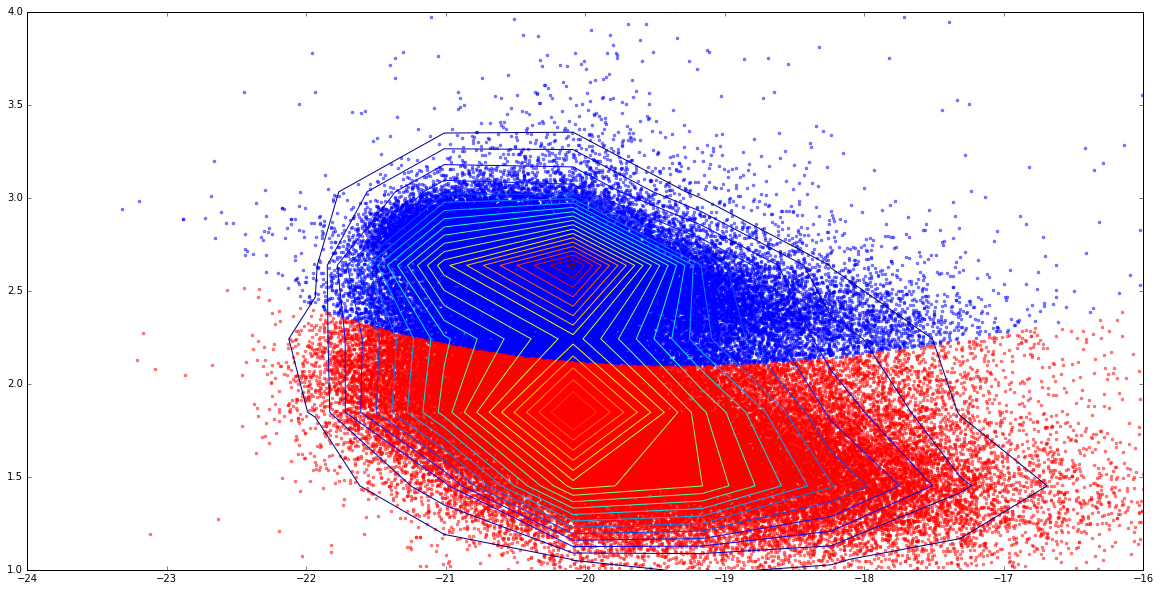

In [81]:
plt.figure(figsize=(20,10))

xpts = np.array([row[0] for row in all_data])
ypts = np.array([row[1] for row in all_data])

pt.plot_contour(xpts,ypts,lines=25)


for i in range(3):
    plt.plot(xpts[tcluster_membership==i], ypts[tcluster_membership==i], '.',color=colors[i],alpha=0.5)
    
plt.xlim(-24,-16)
plt.ylim(1,4)

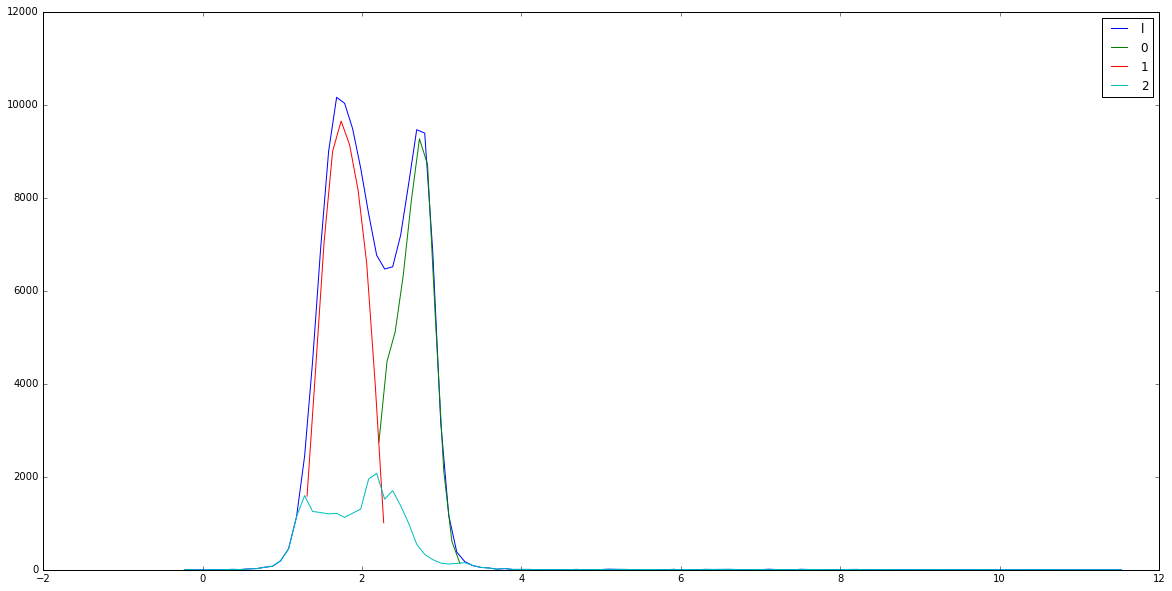

In [82]:
plt.figure(figsize=(20,10))

pt.plot_hist(ypts,200,'l',set_bin_size=True,bin_size=0.1,normed=False)

for i in range(3):
    pt.plot_hist(ypts[cluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.1,normed=False)
plt.legend()    


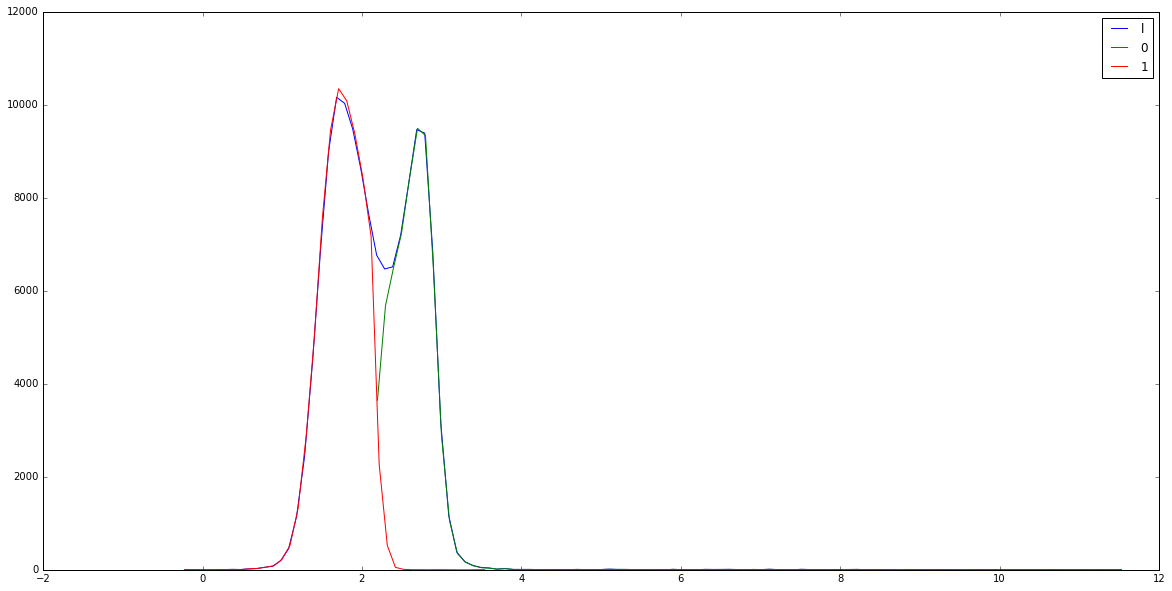

In [84]:
plt.figure(figsize=(20,10))

pt.plot_hist(ypts,200,'l',set_bin_size=True,bin_size=0.1,normed=False)

for i in range(2):
    pt.plot_hist(ypts[tcluster_membership==i],200,str(i),set_bin_size=True,bin_size=0.1,normed=False)
plt.legend()   